In [6]:
x = np.random.randint(1,10,size=10)

In [7]:
x

array([5, 7, 8, 6, 6, 3, 2, 6, 2, 7])

In [12]:
np.random.choice(x,size=(10,10))

array([[3, 7, 6, 6, 6, 2, 7, 3, 6, 2],
       [5, 6, 6, 5, 2, 6, 6, 8, 8, 6],
       [8, 6, 6, 8, 6, 5, 8, 5, 6, 3],
       [2, 7, 6, 7, 6, 2, 7, 2, 7, 2],
       [6, 5, 5, 5, 7, 3, 2, 8, 2, 2],
       [5, 2, 2, 2, 6, 7, 6, 7, 6, 8],
       [6, 8, 8, 8, 7, 5, 7, 7, 3, 8],
       [2, 6, 2, 7, 6, 5, 2, 8, 8, 2],
       [8, 6, 6, 6, 2, 8, 7, 7, 7, 7],
       [6, 3, 7, 8, 3, 6, 2, 6, 6, 6]])

# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [7]:
mom_data = np.array([0.030240902,0.077396207,0.128395695,0.122501281,0.263967196,
                     0.080984111,0.056637622,0.023833931,0.008457201])
mom_data = mom_data[::-1]
weight = np.eye(mom_data.size)

### Set up estimation

In [8]:
Couple = RetirementClass(couple=True, simN=int(1e5), simT=68-53+1)
Couple.solve()
Couple.simulate()

In [9]:
# function to generate moments
def mom_fun(Couple):
    return SMD.MomFunCouple(Couple)

In [44]:
est_par = ["alpha_0_male", "alpha_0_female", "phi_0_male"]
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

In [86]:
Couple.par.start_T = 57-4
Couple.Single.par.start_T = 53-4
Couple.par.simT = 68-(53-4)+1

In [88]:
Couple.solve(recompute=True)
Couple.simulate()

In [40]:
theta = [0.86212266]

In [136]:
theta = [0.8, 0.1, 1]
smd.obj_fun(theta,weight)

Iteration: 28 (0.84 minutes)
 alpha_0_male=0.8000 alpha_0_female=0.1000 phi_0_male=1.0000 -> 0.0348


0.03483083843076848

In [137]:
np.mean(figs.RetAge_C(Couple,ma=0))

59.86295615075694

In [138]:
np.mean(figs.RetAge_C(Couple,ma=1))

61.01856232119123

In [148]:
import transitions

In [149]:
transitions.age(0,Couple.par)

53

In [146]:
Couple.sol.v.shape

(58, 9, 4, 4, 3, 3, 4, 200)

<BarContainer object of 9 artists>

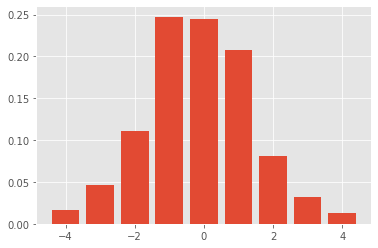

In [144]:
plt.bar(np.arange(-4,5),mom_fun(Couple))
#plt.plot(np.arange(-4,5),mom_fun(Couple),'k--')

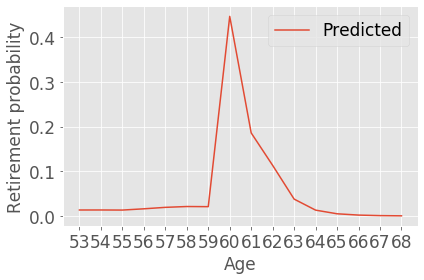

In [140]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0,ages=[53,68]),save=False)

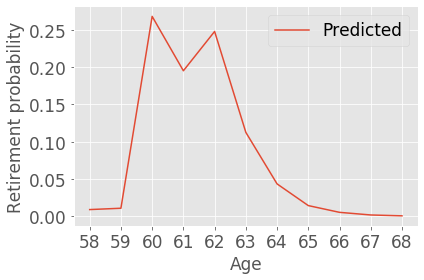

In [141]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1),save=False)

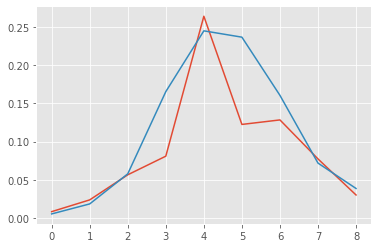

In [103]:
plt.plot(mom_data)
plt.plot(smd.mom_sim)

<BarContainer object of 9 artists>

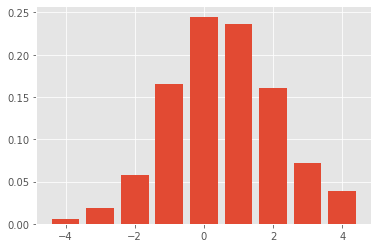

In [104]:
plt.bar(np.arange(-4,5),smd.mom_sim)

<BarContainer object of 9 artists>

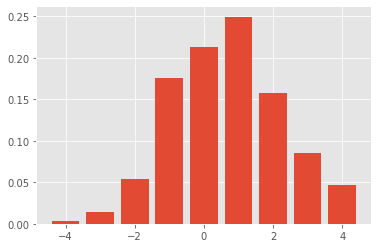

In [33]:
plt.bar(np.arange(-4,5),smd.mom_sim)

### Estimate

In [45]:
theta0 = SMD.start(1,bounds=[(0,1),(0,1),(0,2)])

In [46]:
theta0

[[0.609, 0.965, 0.43]]

In [47]:
smd.print_iter = [True,1]
smd.MultiStart(theta0,weight)
theta = smd.est

Iteration: 1 (0.52 minutes)
 alpha_0_male=0.6090 alpha_0_female=0.9650 phi_0_male=0.4300 -> 0.0234
Iteration: 2 (0.23 minutes)
 alpha_0_male=0.6394 alpha_0_female=0.9650 phi_0_male=0.4300 -> 0.0231
Iteration: 3 (0.24 minutes)
 alpha_0_male=0.6090 alpha_0_female=1.0132 phi_0_male=0.4300 -> 0.0242
Iteration: 4 (0.24 minutes)
 alpha_0_male=0.6090 alpha_0_female=0.9650 phi_0_male=0.4515 -> 0.0235
Iteration: 5 (0.24 minutes)
 alpha_0_male=0.6293 alpha_0_female=0.9167 phi_0_male=0.4443 -> 0.0228
Iteration: 6 (0.23 minutes)
 alpha_0_male=0.6395 alpha_0_female=0.8685 phi_0_male=0.4515 -> 0.0224
Iteration: 7 (0.25 minutes)
 alpha_0_male=0.6496 alpha_0_female=0.9007 phi_0_male=0.4228 -> 0.0224
Iteration: 8 (0.24 minutes)
 alpha_0_male=0.6767 alpha_0_female=0.8578 phi_0_male=0.4396 -> 0.0220
Iteration: 9 (0.24 minutes)
 alpha_0_male=0.7105 alpha_0_female=0.8042 phi_0_male=0.4443 -> 0.0219
Iteration: 10 (0.23 minutes)
 alpha_0_male=0.6936 alpha_0_female=0.7506 phi_0_male=0.4491 -> 0.0226
Iteration

KeyboardInterrupt: 

In [ ]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Couple') # save parameters

In [ ]:
def model_fit(Couple,ma):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')
    mom = moments['Moments'].to_numpy().reshape(2,11)
    data = {'y': [mom[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
            'linestyle': ['None'], 'marker': 'o'}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    return [data,pred]

In [ ]:
np.mean(figs.RetAge_C(Couple,ma=0))

In [ ]:
np.mean(figs.RetAge_C(Couple,ma=1))

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleMen.png')

With moments for hs and elig separately

In [12]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 250 | time: 44.5 min | obj: 2.019647055890923
start par: [0.888, 0.177, 0.96, 0.73, 0.551, 0.633]
par:       [ 0.34486072  0.26388241 -0.29785464  0.89365759  1.18801869  0.53412039]

2 estimation:
success: True | feval: 366 | time: 62.8 min | obj: 2.004012481323837
start par: [0.018, 0.54, -0.567, 0.434, 0.609, 0.93]
par:       [ 0.02513322  0.14277416 -0.10331484  0.77806843  6.11510172 -5.85077245]

3 estimation:
success: True | feval: 278 | time: 49.3 min | obj: 1.8459189271531073
start par: [0.215, 0.631, -0.336, 0.67, 0.006, -0.587]
par:       [ 0.78989092  0.30355572 -0.37230901  0.68057954  0.00623897  0.06052501]

4 estimation:
success: True | feval: 251 | time: 45.6 min | obj: 1.9709075059425873
start par: [0.613, 0.729, 0.122, 0.601, 0.923, -0.159]
par:       [ 0.87503454  0.16559809  0.10386799  0.58150397 -0.13133654 -0.35828139]

5 estimation:
success: True | feval: 270 | time: 48.8 min | obj: 2.003050954422142
start par: [0.748, 0.113

In [14]:
theta

array([ 0.8097936 ,  0.27982001, -0.39997974,  0.68578428,  0.05761685,
       -0.00919087])

In [15]:
smd.obj_fun(theta,weight)

1.848257339210825

In [13]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Couple') # save parameters

Parameters: [ 0.81   0.28  -0.4    0.686  0.058 -0.009]
Std error : [0.0003 0.0002 0.0004 0.0003 0.0006 0.0152]


TypeError: save_est() got an unexpected keyword argument 'couple'

In [16]:
def model_fit(Couple,ma):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')
    mom = moments['Moments'].to_numpy().reshape(2,11)
    data = {'y': [mom[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
            'linestyle': ['None'], 'marker': 'o'}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    return [data,pred]

In [20]:
np.mean(figs.RetAge_C(Couple,ma=0))

61.92561667959754

In [21]:
np.mean(figs.RetAge_C(Couple,ma=1))

62.85268975588876

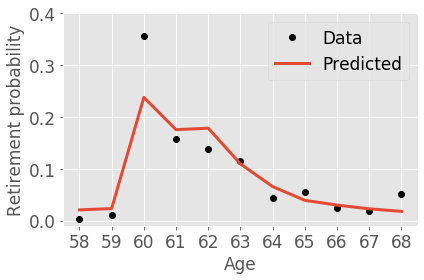

In [17]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleWomen.png')

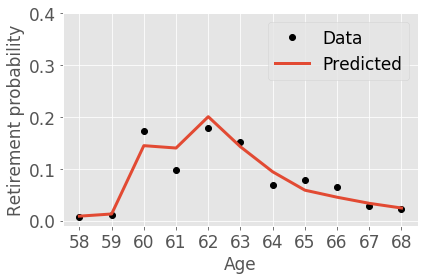

In [18]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/CoupleMen.png')

### Sensitivity to first step calibrated parameters

In [ ]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,est_par_tex,fixed_par_tex[:5]).savefig('figs/Sens/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,est_par_tex,fixed_par_tex[5:]).savefig('figs/Sens/CoupleCali.png')

### Estimate (phi=0)

In [ ]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par[0:4]

In [ ]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8)])

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 100
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='RestCouple',couple=True) # save parameters

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/RestCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/RestCoupleMen.png')